## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                  activation="relu",
                                  name="hidden_layer" + str(i + 1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                  activation="relu",
                                  name="hidden_layer" + str(i + 1))(x)
            x = BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import Callback
import numpy as np


# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    # 預測negative正確
    def TN(self, y_true, y_predict):
        return np.sum((y_true==0)&(y_predict==0))
    # tn = TN(y_test,y_log_predict) # tn = 399

    # 預測positive錯誤
    def FP(self, y_true, y_predict):
        return np.sum((y_true==0)&(y_predict==1))
    # fp = FP(y_test,y_log_predict) # fp = 3

    # 預測negative錯誤
    def FN(self, y_true, y_predict):
        return np.sum((y_true==1)&(y_predict==0))
    # fn = FN(y_test,y_log_predict) # fn = 7

    # 預測positive正確
    def TP(self, y_true, y_predict):
        return np.sum((y_true==1)&(y_predict==1))
    # tp = TP(y_test,y_log_predict) # tp = 41
    
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        print('tp precision_score :\n', self.TP(y_true, y_pred))
        print('tn precision_score :\n', self.TN(y_true, y_pred))
        
        logs["val_fp"] = self.FP(y_true, y_pred)
        logs["val_fn"] = self.FN(y_true, y_pred)
        logs["val_tp"] = self.TP(y_true, y_pred)
        logs["val_tn"] = self.TN(y_true, y_pred)
        
rec_tptn = Record_tp_tn()

In [8]:
"""
# 載入 Callbacks，撰寫一個 f1 score 的 callback function
"""

from keras.callbacks import Callback
from sklearn.metrics import f1_score

class f1sc(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

In [9]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         validation_data=(x_test, y_test),
         shuffle=True,
         callbacks=[log_f1sc, rec_tptn])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# 在訓練後，將 f1sc 紀錄調出
valid_f1sc = model.history.history['val_f1sc']

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""

valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024

/Users/beemolin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


tp precision_score :
 0
tn precision_score :
 1000
Epoch 2/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.7664 - accuracy: 0.3861 - val_loss: 2.0004 - val_accuracy: 0.2972
tp precision_score :
 0
tn precision_score :
 1000
Epoch 3/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.6316 - accuracy: 0.4278 - val_loss: 1.8574 - val_accuracy: 0.3479
tp precision_score :
 6
tn precision_score :
 1000
Epoch 4/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.5545 - accuracy: 0.4516 - val_loss: 1.7417 - val_accuracy: 0.3897
tp precision_score :
 24
tn precision_score :
 1000
Epoch 5/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.5002 - accuracy: 0.4722 - val_loss: 1.6557 - val_accuracy: 0.4138
tp precision_score :
 83
tn precision_score :
 1000
Epoch 6/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.4566 - accuracy: 0.4889 - val_loss: 1.6007 - val_accuracy: 0.4343
tp preci

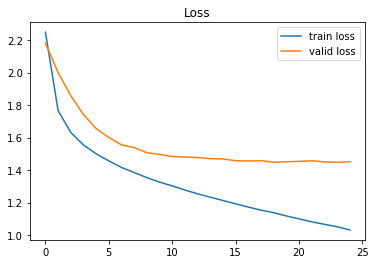

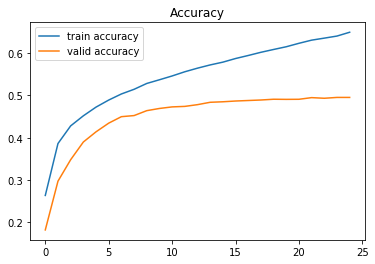

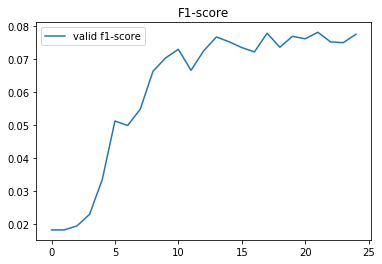

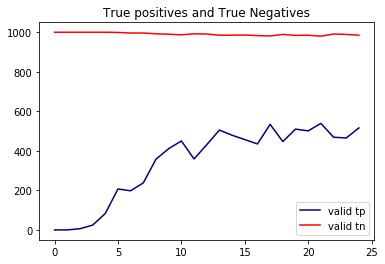

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
